
# Моделирование задачи оттока клиентов

## Разбиение датасета
Датасет был разбит на тренировочную и тестовую выборки с использованием функции `train_test_split`.

## Константная модель
Для начала была построена константная модель, которая всегда предсказывает наиболее частый класс (без оттока). Это служит простым бейзлайном для оценки качества.

## Логистическая регрессия
Затем была обучена простая модель логистической регрессии для улучшения точности предсказаний.


In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [2]:
##For this churn problem - the data is being loaded from https://www.kaggle.com/blastchar/telco-customer-churn

file = '/WA_Fn-UseC_-Telco-Customer-Churn.csv'

churn_data = pd.read_csv(file)

In [3]:
churn_data.columns = [col.title() for col in churn_data.columns]
churn_data.head()

,Customerid,Gender,Seniorcitizen,Partner,Dependents,Tenure,Phoneservice,Multiplelines,Internetservice,Onlinesecurity,...,Deviceprotection,Techsupport,Streamingtv,Streamingmovies,Contract,Paperlessbilling,Paymentmethod,Monthlycharges,Totalcharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn_data.dtypes

,0
Customerid,object
Gender,object
Seniorcitizen,int64
Partner,object
Dependents,object
Tenure,int64
Phoneservice,object
Multiplelines,object
Internetservice,object
Onlinesecurity,object


Наш базовый уровень будет случайным образом назначать класс — 0/1 для «Без оттока»/«Оттока» соответственно.

Здесь я выбираю три модели - линейную регрессию для оценки вероятности класса, поскольку она основана на расстояниях, и модель случайного леса на основе дерева для получения информации с помощью функций. Позже мы сможем создать ансамблевые модели, комбинируя их.

In [5]:
# Проверим, существуют ли нужные колонки перед преобразованиями
if 'Tenure' in churn_data.columns and 'Monthlycharges' in churn_data.columns and 'Totalcharges' in churn_data.columns:
    # Преобразуем нужные столбцы
    churn_data['Tenure_in_yrs'] = churn_data['Tenure'] // 12
    churn_data['Monthlycharges_100s'] = round(churn_data['Monthlycharges'] / 100, 2)

    # Преобразуем TotalCharges в числовой формат и пересчитаем в тысячах
    churn_data['Totalcharges'] = pd.to_numeric(churn_data['Totalcharges'], errors='coerce').fillna(0)
    churn_data['Totalcharges_1000s'] = round(churn_data['Totalcharges'] / 1000, 2)

    # Удаляем оригинальные столбцы
    churn_data.drop(columns=['Tenure', 'Monthlycharges', 'Totalcharges'], inplace=True)
else:
    print("Одного из столбцов 'Tenure', 'MonthlyCharges' или 'TotalCharges' не существует.")

# Заменяем значения 'No phone service' и 'No internet service' на 'No'
churn_data = churn_data.replace({'No phone service': 'No', 'No internet service': 'No'})


In [6]:
def transform_categorical_data(df, cols, drop_first=True, convert_ascat = True):
    """
    Transform categorical data in the columns into dummy data using pandas.
    ----------
    df : Dataframe
    cols : categorical columns to be converted into dummy data
    drop_orgnl : Boolean, if set to True drops the original column.
    drop_first : Boolean if True drops one of the dummy column
    convert_ascat : convert columns into categorical.

    Return
    -------
    Dataframe with the original frame concatenated with dummy data
    """
    from sklearn.preprocessing import LabelEncoder

    if convert_ascat == True:
        df[cols] = df[cols].astype('category')
    binary_cols = [c for c in cols if df[c].nunique() ==2]
    multi_cols = [ c for c in cols if c not in binary_cols]


    le = LabelEncoder()
    for i in binary_cols:
        df[i] = le.fit_transform(df[i])

    df = pd.get_dummies(data = df,columns = multi_cols, drop_first=drop_first)

    return df

In [7]:
#taking all the columns except for the customer id
cat_cols = [col for col in churn_data.columns if (churn_data[col].dtype.name in ['object','category'])]

churn_data = transform_categorical_data(churn_data, cat_cols)
churn_data.head()

,Gender,Seniorcitizen,Partner,Dependents,Phoneservice,Multiplelines,Onlinesecurity,Onlinebackup,Deviceprotection,Techsupport,...,Customerid_9992-UJOEL,Customerid_9993-LHIEB,Customerid_9995-HOTOH,Internetservice_Fiber optic,Internetservice_No,Contract_One year,Contract_Two year,Paymentmethod_Credit card (automatic),Paymentmethod_Electronic check,Paymentmethod_Mailed check
0,0,0,1,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,1,0,1,0,1,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,1,0,1,1,0,0,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,0,0,1,0,1,1,...,False,False,False,False,False,True,False,False,False,False
4,0,0,0,0,1,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [8]:
churn_data.columns

Index(['Gender', 'Seniorcitizen', 'Partner', 'Dependents', 'Phoneservice',
       'Multiplelines', 'Onlinesecurity', 'Onlinebackup', 'Deviceprotection',
       'Techsupport',
       ...
       'Customerid_9992-UJOEL', 'Customerid_9993-LHIEB',
       'Customerid_9995-HOTOH', 'Internetservice_Fiber optic',
       'Internetservice_No', 'Contract_One year', 'Contract_Two year',
       'Paymentmethod_Credit card (automatic)',
       'Paymentmethod_Electronic check', 'Paymentmethod_Mailed check'],
      dtype='object', length=7066)

In [9]:
#creating a new feature family that captures if a customer has a partner or dependents (children or parents)
churn_data['Family'] = np.where((churn_data['Partner'] == 1) |(churn_data['Dependents'] == 1),1,0)
churn_data.drop(columns=['Partner','Dependents'],inplace=True)

In [10]:
#removing Total charges also as its highly related to monthly charges and tenure.
X, Y = churn_data.drop(columns=['Churn','Totalcharges_1000s']), churn_data.Churn

In [11]:
#creating a baseline predictor that randomly assigns a customer as churn or no churn
def baseline_pred(X, y_true):
    from numpy.random import rand, randint
    y_pred = [randint(0,2) for i in range(X.shape[0])]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = round(tp/X.shape[0],3)
    print('baseline accuracy is {}'.format(accuracy))

baseline_pred(X, Y)

baseline accuracy is 0.131


In [12]:
#defining the metrics we want to use to compare for each model
def classification_metrics(y_true, y_pred, model, y_prob, ret_results = True, print_res = True):
    """
    Calculates different classification metrics for the model, and prints out the results
    ----------
    y_true : actual output values
    y_pred : predicted values based on the model
    model : Classification model with already training data fitted on the model
    ret_results : To return different metrics as a dictionary
    print_res : prints out the metrics as well as roc curve.

    Return
    -------
    Returns a dictionary with different metrics if ret_results is set to True
    """
    import matplotlib.pyplot as plt

    #balanced accuracy score
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
    acc = round(accuracy_score(y_true, y_pred),3)
    bal_acc = round(balanced_accuracy_score(y_true, y_pred),3)
    #sensitivity and specificity - identifiying churning customers more important than stable customers
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(tp/(tp+fn), 3)
    specificity = round(tn/(tn+fp), 3)

    #auc score
    fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
    auc_score = round(auc(fpr, tpr), 3)
    res_dict = {'Accuracy':acc, 'Balanced acc':bal_acc, 'sensitivity': sensitivity,
                'specificity':specificity, 'auc':auc_score}

    if print_res == True:
        print(model)
        print(res_dict)

        plt.grid()
        plt.plot(fpr,tpr)
        plt.fill_between(fpr, tpr, color = 'silver')
        plt.annotate('Area under Curve {}'.format(auc_score), (0,0.9), fontsize = 10)
        plt.title('ROC Curve')
        plt.show()

    if ret_results == True:
        return res_dict


In [13]:
# need to generalize this function with any model and its additional parameters


def model_CVsplit_metrics(X, Y, model, size = 0.4, random_st = 16):
    """
    Fits the classification model with a train test split and calculates and displays the metrics
    ----------
    X : input data set
    Y : output labels
    model : Classification model with parameters tuned.
    size : Size of the test for the train_test_split
    random_st : random state value

    Return
    -------
    Returns the model with fitted data
    """
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=size, random_state = random_st)

    model = model.fit(X_train,y_train)

    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)

    print('test score {0:.3g}'.format(test_score))
    print('training score {0:.3g}'.format(train_score))

    y_hat = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    classification_metrics(y_true = y_test, y_pred=y_hat, model=model, y_prob=y_proba, ret_results= False)
    return model

test score 0.798
training score 0.878
LogisticRegression(solver='liblinear')
{'Accuracy': 0.798, 'Balanced acc': 0.717, 'sensitivity': 0.55, 'specificity': 0.885, 'auc': 0.84}


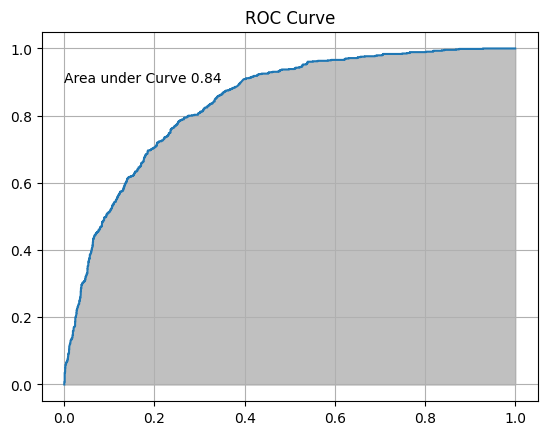

In [14]:
#applying logistic regression
logit = LogisticRegression(solver='liblinear')
logit = model_CVsplit_metrics(X, Y, model= logit)

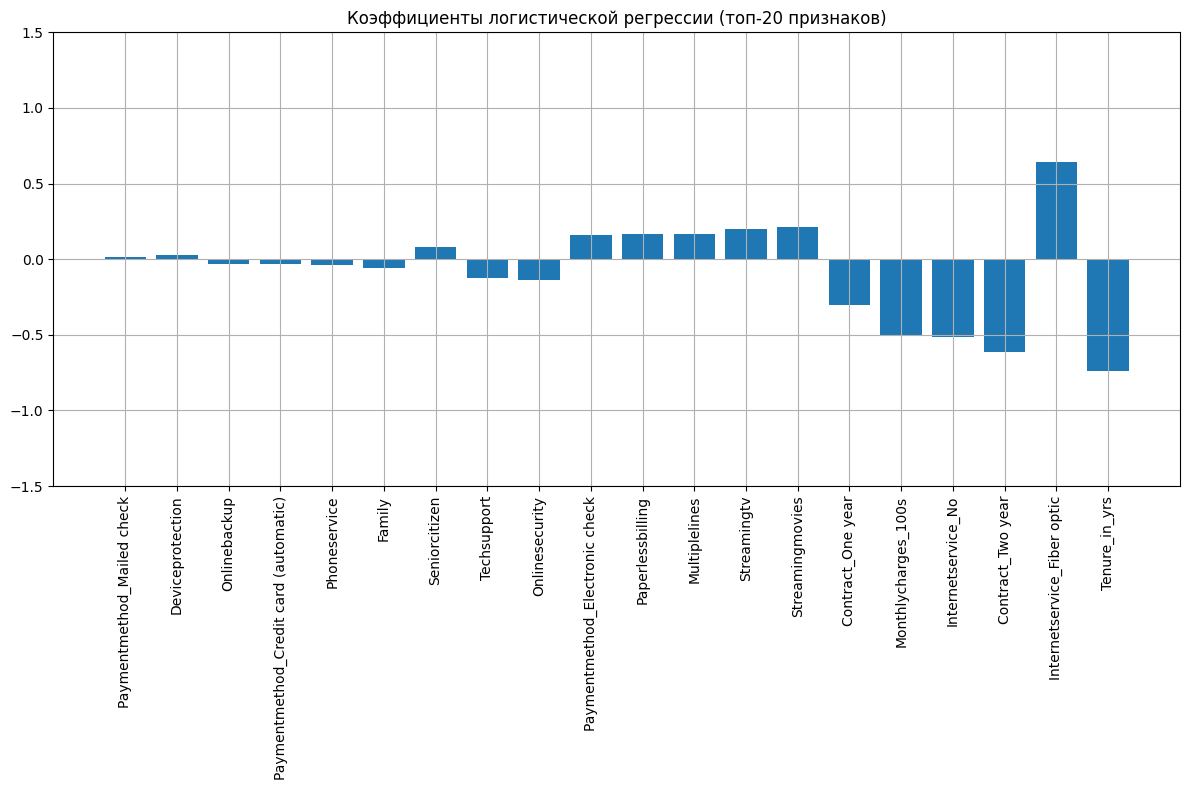

In [17]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Удаление всех столбцов, содержащих 'CustomerID'
X_filtered = X.drop(columns=[col for col in X.columns if 'CustomerID' in col or 'customer' in col.lower()])

# Масштабируем данные после удаления ненужных признаков
scaler = StandardScaler()  # Инициализация StandardScaler
X_scaled = scaler.fit_transform(X_filtered)

# Обучение модели
logit.fit(X_scaled, Y)

# Отображение топ-20 значимых признаков
coef = logit.coef_[0]
top_indices = np.argsort(np.abs(coef))[-20:]  # Топ-20 по абсолютным значениям

# Построение графика для топ-20 признаков
plt.figure(figsize=(12, 8))
plt.bar(x=X_filtered.columns[top_indices], height=coef[top_indices])
plt.xticks(rotation=90)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.title("Коэффициенты логистической регрессии (топ-20 признаков)")
plt.tight_layout()
plt.show()


test score 0.765
training score 1
KNeighborsClassifier(weights='distance')
{'Accuracy': 0.765, 'Balanced acc': 0.691, 'sensitivity': 0.536, 'specificity': 0.845, 'auc': 0.781}


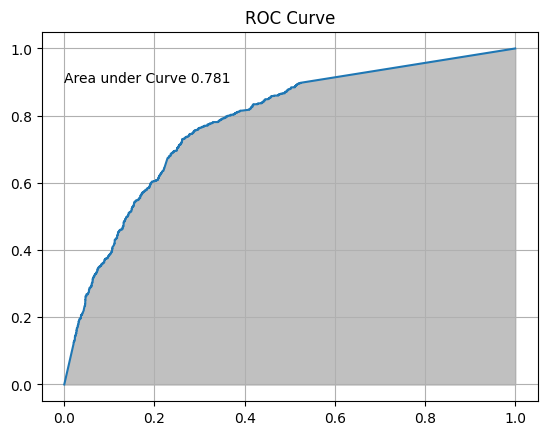

In [18]:
knn_model = KNeighborsClassifier(weights='distance')
knn_model = model_CVsplit_metrics(X,Y, knn_model)

test score 0.79
training score 1
RandomForestClassifier()
{'Accuracy': 0.79, 'Balanced acc': 0.688, 'sensitivity': 0.473, 'specificity': 0.902, 'auc': 0.827}


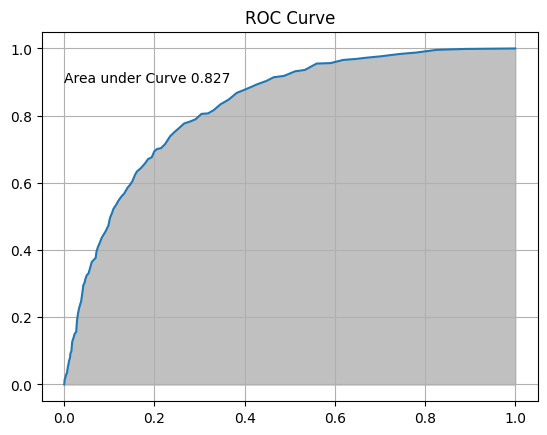

In [19]:
rnd_forest = RandomForestClassifier(n_estimators=100)
rnd_forest = model_CVsplit_metrics(X,Y,rnd_forest)

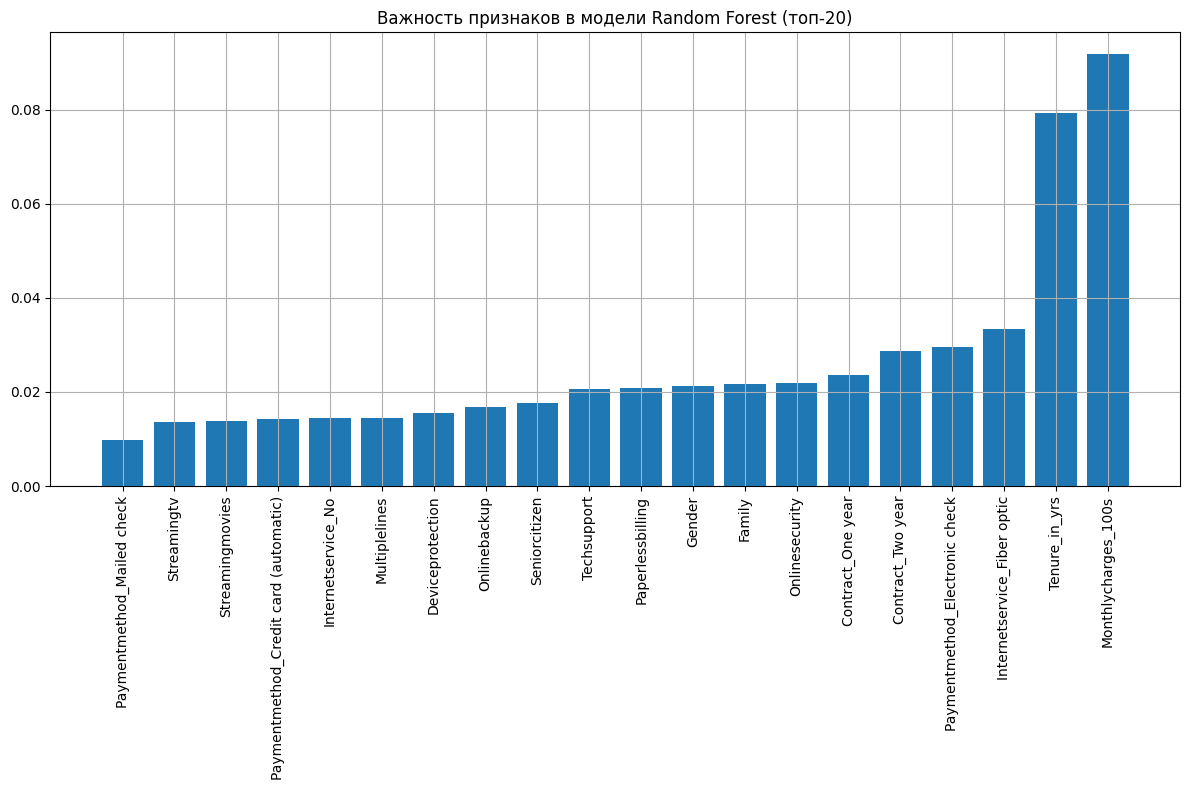

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем индексы топ-20 наиболее значимых признаков
top_indices = np.argsort(rnd_forest.feature_importances_)[-20:]

# Увеличим размер графика для лучшей видимости
plt.figure(figsize=(12, 8))

# Строим график для топ-20 признаков
plt.bar(x=X.columns[top_indices], height=rnd_forest.feature_importances_[top_indices])
plt.xticks(rotation=90)  # Поворот подписей
plt.grid(True)
plt.title("Важность признаков в модели Random Forest (топ-20)")
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()


In [21]:
#lets try voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

vclf = VotingClassifier(estimators=[('lr',logit),('knn',knn_model),('rf',rnd_forest)], voting='hard')
for clf, label in zip([logit, knn_model, rnd_forest, vclf], ['Logistic reg','KNN classification','Random forest','Voting ensemble']):
    scores = cross_val_score(clf, X, Y, scoring ='accuracy', cv=5)
    print('Accuracy : %0.3f (+/- %0.2f) [%s]'%(scores.mean(), scores.std(), label))


Accuracy : 0.798 (+/- 0.01) [Logistic reg]
Accuracy : 0.770 (+/- 0.01) [KNN classification]
Accuracy : 0.793 (+/- 0.01) [Random forest]
Accuracy : 0.794 (+/- 0.01) [Voting ensemble]


Сбалансированная точность примерно на 10% ниже фактической точности. Это может быть признаком несбалансированных классов. Можно попробовать применить некоторые методы выборки, чтобы посмотреть, улучшит ли это прогноз.

Логистическая регрессия работает лучше. Точность лучше, чем у любой из моделей, и даже его производительность (auc) лучше, чем у других моделей.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Задание параметров (сузим диапазоны для ускорения)
parameters = {
    'penalty': ['l2'],  # Суже диапазон
    'C': [0.1, 1, 10],  # Меньше значений
    'max_iter': [200, 400],  # Уменьшено число итераций
    'solver': ['liblinear']
}

logit_tune = LogisticRegression()

# GridSearchCV с параллельным выполнением
gridclf = GridSearchCV(logit_tune, parameters, scoring=['accuracy', 'roc_auc'], refit='accuracy', cv=3, n_jobs=-1)
gridclf.fit(X_scaled, Y)

# Лучшие параметры и оценка модели
best_params = gridclf.best_params_
best_score = gridclf.best_score_

print("Лучшие параметры:", best_params)
print("Лучшая точность:", best_score)



Лучшие параметры: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Лучшая точность: 0.7023995739725487


In [23]:
gridclf.best_params_

{'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

In [24]:
gridclf.best_estimator_

LogisticRegression(C=10, max_iter=200, solver='liblinear')

In [25]:
gridclf.best_score_

0.7023995739725487

In [26]:
gridclf.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))}

In [27]:
grid_scores = cross_val_score(gridclf.best_estimator_, X, Y, scoring = 'accuracy', cv = 5)
print('Accuracy = %0.3f(+/- %0.2f)'%(grid_scores.mean(), grid_scores.std()))

Accuracy = 0.798(+/- 0.01)


In [28]:
#hypertuning random forest based on no of estimators
#from IPython.display import display
# no of trees can change the overall performance of the model. So lets use auc score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.4, random_state = 42)
estimators_list = [1,2,3,4,5,10,15,20,30,50,70,80,100,120, 140,150,200, 220, 240, 250 ]
auc_score = []

for estimator in estimators_list:
    model = RandomForestClassifier(n_estimators=estimator, random_state=42)
    model.fit(X_train,y_train)
    auc_score.append(roc_auc_score(y_test, model.predict(X_test)))

print(DataFrame({'num_estimator':estimators_list, 'auc':auc_score}))

    num_estimator       auc
0               1  0.661127
1               2  0.607632
2               3  0.662113
3               4  0.633990
4               5  0.678500
5              10  0.653095
6              15  0.675275
7              20  0.667712
8              30  0.671476
9              50  0.673179
10             70  0.675792
11             80  0.677852
12            100  0.680522
13            120  0.681432
14            140  0.686346
15            150  0.683618
16            200  0.682410
17            220  0.683319
18            240  0.681927
19            250  0.683504


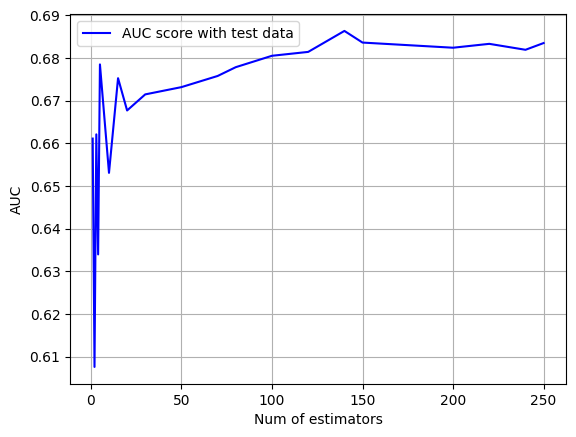

In [30]:
plt.plot(estimators_list, auc_score, 'b', label='AUC score with test data')
plt.grid(True)  # Включение сетки
plt.xlabel('Num of estimators')
plt.ylabel('AUC')
plt.legend()
plt.show()

Производительность лучше для классификатора с числом 80–100 оценщиков.

   depth  train_accuracy  test_accuracy
0      1        0.734911       0.734209
1      2        0.734911       0.734209
2      3        0.734911       0.734209
3      4        0.734911       0.734209
4      5        0.734911       0.734209
5     10        0.734911       0.734209
6     15        0.734911       0.734209
7     20        0.738935       0.735628
8     50        0.945562       0.793825
9    100        0.999763       0.798439


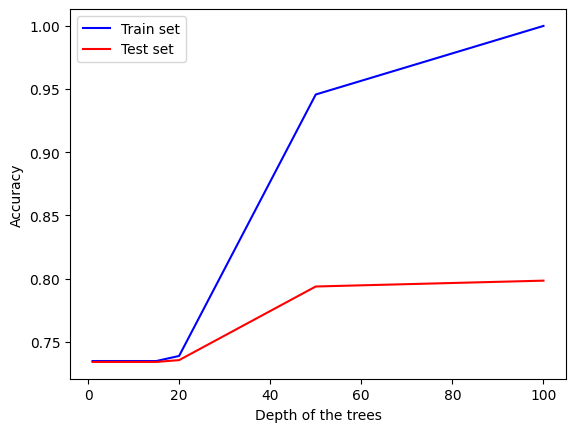

In [31]:
#hypertuning depth of the rnd forest classifier
# Depth effects the complexity of each tree. In order to balance bias vs trade-off compare with different depths.

from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

depth_list = [1,2,3,4,5,10,15,20,50,100]
test_results = []
train_results = []

for depth in depth_list:
    model2 = RandomForestClassifier(max_depth=depth, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))

print(DataFrame({'depth':depth_list, 'train_accuracy':train_results, 'test_accuracy':test_results}))

plt.plot(depth_list, train_results, 'b', label='Train set')
plt.plot(depth_list, test_results, 'r', label = 'Test set')
plt.xlabel('Depth of the trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

На глубине 5 уровней максимальная точность теста составляет 80,3%, а точность обучения — всего 79,5%.
Однако на глубине 10 уровней точность теста существенно меняется, а точность обучения повышается до 86%.

Мы можем выполнить поиск по сетке между 5–10 уровнями вместе с другими гипернастраиваемыми параметрами.

  feat size  train_accuracy  test_accuracy
0      sqrt        1.000000       0.796664
1      log2        1.000000       0.796664
2       1.0        0.999763       0.803407
3       0.7        1.000000       0.805891
4       0.5        0.999763       0.805891
5       0.3        0.999763       0.806246
6       0.1        1.000000       0.797729


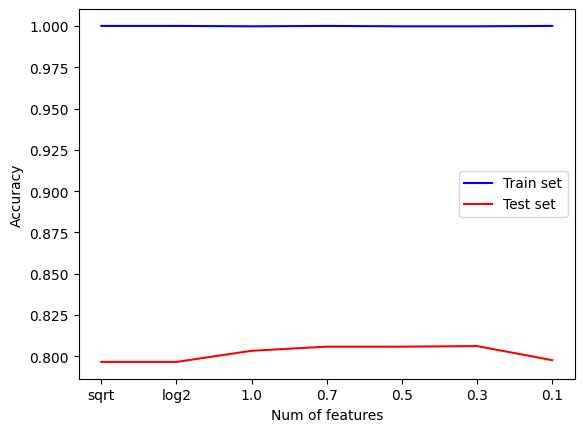

In [32]:
#Max features indicates the no . of features to consider for each split.
#More features indicates more levels of split to have a better entropy.

max_features_list = ['sqrt', 'log2', 1.0, 0.7, 0.5, 0.3, 0.1]

test_results = []
train_results = []

for feat_size in max_features_list:
    model2 = RandomForestClassifier(max_features = feat_size, random_state= 42)
    model2.fit(X_train,y_train)
    train_results.append(model2.score(X_train, y_train))
    test_results.append(model2.score(X_test, y_test))

print(DataFrame({'feat size':max_features_list, 'train_accuracy':train_results, 'test_accuracy':test_results}))

plt.plot(max_features_list, train_results, 'b', label='Train set')
plt.plot(max_features_list, test_results, 'r', label = 'Test set')
plt.xlabel('Num of features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


С 0,3% точность еще лучше. Это от 6 до 7 функций. (0,3*21)

In [33]:
#lets try gridsearch with these values

from sklearn.model_selection import GridSearchCV
from warnings import simplefilter

simplefilter(action='ignore', category = FutureWarning)

parameters = {'n_estimators':[80,100], 'max_depth':[5,7,10], 'max_features':[6,7]}

#defining the grid classifier estimator
rnd_forest = RandomForestClassifier()
rnd_forest_GridCV = GridSearchCV(rnd_forest, parameters, scoring=['accuracy', 'roc_auc'], refit = 'accuracy', cv = 5 )

#fitting the data on the model estimator
rnd_forest_GridCV.fit(X,Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 7, 10], 'max_features': [6, 7],
                         'n_estimators': [80, 100]},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [34]:
rnd_forest_GridCV.best_score_

0.7346301575908123

In [35]:
rnd_forest_GridCV.best_estimator_

RandomForestClassifier(max_depth=5, max_features=6, n_estimators=80)

test score 0.739
training score 0.732
RandomForestClassifier(max_depth=5, max_features=6, n_estimators=80)
{'Accuracy': 0.739, 'Balanced acc': 0.5, 'sensitivity': 0.0, 'specificity': 1.0, 'auc': 0.703}


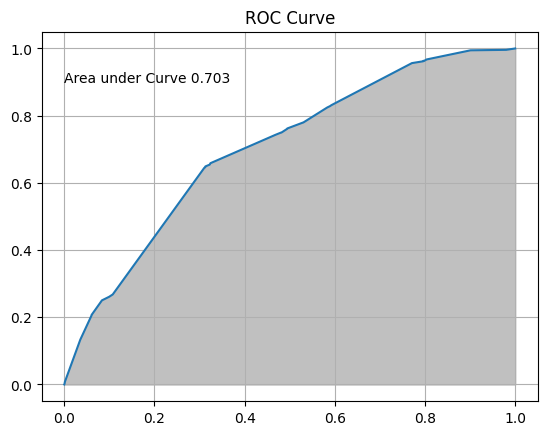

RandomForestClassifier(max_depth=5, max_features=6, n_estimators=80)

In [36]:
model_CVsplit_metrics(X,Y,rnd_forest_GridCV.best_estimator_)

Использование лучшего классификатора случайного леса дало мне точность 80,4% по сравнению с логистической регрессией (79,7%), но производительность обеих моделей (показатель AUC) одинакова.

Хотя случайный лес дает лучшую дисперсию с дополнительной информацией в данных, такой как объем данных, используемых с телефонной связью, подписки на полосу пропускания с интернет-услугами и т. д., модель случайного леса может быть лучше использована для преодоления сложности.

С текущими данными можно считать, что логистическая регрессия позволяет создать простую и понятную модель.

In [37]:
# Ensuring reproducibility with fixed random_state
random_state = 42